## 목표
---
1. **ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?**  
    - 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. **구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?**
    - cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. **Ablation Study 결과가 바른 포맷으로 제출되었는가?**
    - ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

---


## STEP 0. 라이브러리 불러오기
---

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import warnings
import tensorflow_datasets as tfds
warnings.filterwarnings("ignore")

## STEP 1. ResNet 기본 블록 구성하기
---
금번에 만들어볼 ResNet-34와 ResNet-50 블록의 공통점을 찾아 기본 블록을 구성해보자.

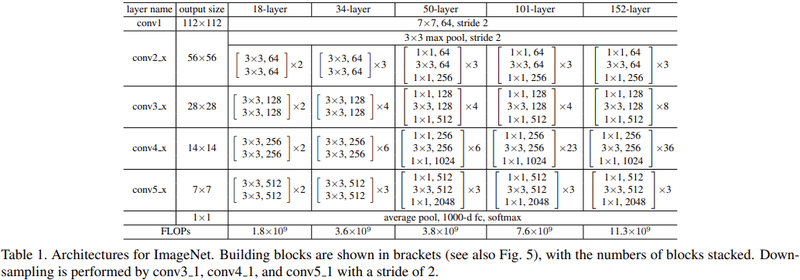

- 공통점 : conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태
- 차이점 : ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다름. 
    - ResNet-34 : 3x3 kernel인 Convolution layer로만 구성
    - ResNet-50 : 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록내에 가지게 됨


### ResNet-34 모델
---

우선 기본 블럭만 만들고 input 쪽에 maxpooling은 나중에 클래스로 묶을 때 따로 만들기로 하자. 

In [ ]:
############ ResNet 34 Block 만들기 ####################
def build_34_layer_block(input_layer,
                          num_cnn = 3,
                          channel = 64,
                          block_num = 1,
                          strides = 1,
                          is_residual = True):
    
    #입력 레이어
    x = input_layer

    #CNN 레이어
    for cnn_num in range(num_cnn):
        #identity mapping 설정
        identity_mapping = x
        ########### layer1 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = channel,
                                kernel_size = (3,3),
                                strides = strides,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}'
                                )(x)
                                
        # conv2D 다음 Batch normalization
        x = keras.layers.BatchNormalization()(x)
        # BN 다음 activation(relu)
        x = keras.layers.Activation('relu')(x)

        ########### layer2 ##############
        # conv2D
        x = keras.layers.Conv2D(filters = channel,
                                strides = 1,
                                kernel_size = (3,3),
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'blcok{block_num}_conv{cnn_num}'
                                )(x)
        # conv2D 다음 Batch normalization
        x = keras.layers.BatchNormalization()(x)

        if is_residual:
            ########### skip connections #############
           if strides != 1 :
                # identity mapping conv 진행
                identity_mapping = keras.layers.Conv2D(filters = channel,
                                                    kernel_size = (1,1),
                                                    strides = 2)(identity_mapping)
                # conv2D 다음 Batch normalization
                identity_mapping = keras.layers.BatchNormalization()(identity_mapping)
                # 다음 스텝용 strides 변경
                srides = 1

           ########### Residual addition ##############
           #identity mapping 더해주는 레이어
           x = keras.layers.Add()([x, identity_mapping])
           # Add 후 activation(relu)

        x = keras.layers.Activation('relu')(x)


    return x


Ok.... 우선 블럭 1개짜리는 잘 생성되었습니다!!!

그럼 이제 input에서 maxpooling과 나머지 블록들까지 합쳐서 ResNet 34 model을 만들어 봅시다. 

In [ ]:
############ ResNet 34 Model 만들기 ####################
def build_resnet_34(input_shape = (32,32,3),
                 num_cnn_list = [3,4,6,3],
                 channel_list = [64,128,256,512],
                 num_classes = 10,
                 is_residual = True):
    
    # 모델 돌리기 전에 config list 길이 확인
    assert len(num_cnn_list) == len(channel_list)


    ############ input layer 생성 ###########
    input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
    output = keras.layers.Conv2D(filters = channel_list[0],
                                 kernel_size = (1,1),
                                 strides = 2,
                                 kernel_initializer = 'he_normal',
                                 padding = 'same',
                                 name = 'conv2D_1st')(input_layer)
    # conv2D 다음 Batch normalization
    output = keras.layers.BatchNormalization()(output)
    # BN 다음 activation(relu)
    output = keras.layers.Activation('relu')(output)
    # maxpooling
    output = keras.layers.MaxPool2D(pool_size=(1, 1),
                               strides = 2)(output)
    
    ############# Conv layer 생성 ###############
    #config list 길이만큼 반복해서 블록 생성 
    prev_channel = channel_list[0]
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        strides = 1 if channel == prev_channel else 2
        output = build_34_layer_block(output,
                                       num_cnn = num_cnn,
                                       channel = channel,
                                       strides = strides,
                                       block_num = i)
        prev_channel = channel
        

    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'softmax', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model



In [ ]:
resnet_34 = build_resnet_34(input_shape=(32,32,3))
resnet_34.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_1st (Conv2D)            (None, 16, 16, 64)   256         ['InputLayer[0][0]']             
                                                                                                  
 batch_normalization_777 (Batch  (None, 16, 16, 64)  256         ['conv2D_1st[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_631 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_777[

### ResNet 50
---


In [161]:
############ ResNet 50 Block 만들기 ####################
def build_ResNet_50_block(input_layer,
                          num_cnn = 3,
                          channel = 64,
                          block_num = 1,
                          strides = 1,
                          is_residual = True):
    
    #입력 레이어
    x = input_layer
    
    #CNN 레이어
    for cnn_num in range(num_cnn):
        #identity mapping 설정
        identity_mapping = x

        ########### layer1 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = channel,
                                kernel_size = (1,1),
                                strides = strides,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}_1x1_1st'
                                )(x)
                                
        # conv2D 다음 BN-ReLU
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        ########### layer2 ##############
        # conv2D
        x = keras.layers.Conv2D(filters = channel,
                                strides = 1,
                                kernel_size = (3,3),
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'blcok{block_num}_conv{cnn_num}_3x3'
                                )(x)
        # conv2D 다음 BN-ReLU
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        ########### layer3 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = (channel * 4),
                                kernel_size = (1,1),
                                strides = 1,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}_1x1_2nd'
                                )(x)
        # conv2D 다음 BN
        x = keras.layers.BatchNormalization()(x)
        if is_residual = True:
            if strides == 1: 
                identity_mapping = keras.layers.Conv2D(filters = (channel * 4),
                                                        kernel_size = (1,1),
                                                        padding = 'same',
                                                        strides = strides)(identity_mapping)
                # conv2D 다음 BN
                identity_mapping = keras.layers.BatchNormalization()(identity_mapping)

            ########### skip connections #############
            else:
                # identity mapping conv 진행
                identity_mapping = keras.layers.Conv2D(filters = (channel * 4),
                                                        kernel_size = (1,1),
                                                        strides = 2)(identity_mapping)
                # conv2D 다음 Batch normalization
                identity_mapping = keras.layers.BatchNormalization()(identity_mapping)
                # 다음 스텝용 strides 변경
                strides = 1

            ########### Residual addition ##############
            #identity mapping 더해주는 레이어
            x = keras.layers.Add()([x, identity_mapping])
        # Add 후 activation(relu)
        x = keras.layers.Activation('relu', name = f'block{block_num}_conv{cnn_num}_out')(x)


    return x


SyntaxError: ignored

In [162]:
############ ResNet 50 Model 만들기 #################### 수정수정
def build_resnet_50(input_shape = (32,32,3),
                 num_cnn_list = [3,4,6,3],
                 channel_list = [64,128,256,512],
                 num_classes = 10):
    
    # 모델 돌리기 전에 config list 길이 확인
    assert len(num_cnn_list) == len(channel_list)

    ############ input layer 생성 ###########
    input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
    output = keras.layers.Conv2D(filters = channel_list[0],
                                 kernel_size = (1,1),
                                 strides = 2,
                                 kernel_initializer = 'he_normal',
                                 padding = 'same',
                                 name = 'conv2D_1st')(input_layer)
    # conv2D 다음 Batch normalization
    output = keras.layers.BatchNormalization()(output)
    # BN 다음 activation(relu)
    output = keras.layers.Activation('relu')(output)
    # maxpooling
    output = keras.layers.MaxPool2D(pool_size=(1, 1),
                               strides = 2)(output)
    
    ############# Conv layer 생성 ###############
    #config list 길이만큼 반복해서 블록 생성 
    prev_channel = channel_list[0]
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        strides = 1 if channel == prev_channel else 2
        output = build_ResNet_50_block(output,
                                       num_cnn = num_cnn,
                                       channel = channel,
                                       strides = strides,
                                       block_num = i)
        prev_channel = channel
        

    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'softmax', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model

In [163]:
resnet_50 = build_resnet_50()

resnet_50.summary()


tf.keras.utils.plot_model(resnet_50, 'model.png', show_shapes = True)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_1st (Conv2D)            (None, 16, 16, 64)   256         ['InputLayer[0][0]']             
                                                                                                  
 batch_normalization_1063 (Batc  (None, 16, 16, 64)  256         ['conv2D_1st[0][0]']             
 hNormalization)                                                                                  
                                                                                                  
 activation_788 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_1063

In [168]:
############## build_resnet ##############
def build_resnet(input_shape, num_classes, is_50):

    ############ input layer 생성 ###########
    input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
    output = keras.layers.Conv2D(filters = channel_list[0],
                                 kernel_size = (1,1),
                                 strides = 2,
                                 kernel_initializer = 'he_normal',
                                 padding = 'same',
                                 name = 'conv2D_1st')(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    # maxpooling
    output = keras.layers.MaxPool2D(pool_size=(1, 1),
                               strides = 2)(output)


    # 모델 돌리기 전에 config list 길이 확인
    assert len(num_cnn_list) == len(channel_list)
    #config list 길이만큼 반복해서 블록 생성 
    prev_channel = channel_list[0]

    if is_50 :

        num_cnn_list = [3,4,6,3],
        channel_list = [64,128,256,512],
        num_classes = 10

        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_ResNet_50_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i)
            prev_channel = channel

    else:
        num_cnn_list = [3,4,6,3],
        channel_list = [64,128,256,512],
                num_classes = 10

        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_ResNet_50_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i)
            prev_channel = channel

        

    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'softmax', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model




In [ ]:
########### build_plainnet ##############

build_plainnet